# EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy import fftpack

In [4]:
raw_data = "../raw/train.csv"
sub_data = "../raw/sample_submission.csv"
test_data = "../raw/test/{}.csv" 
proc_data = "../processed/{}"

In [8]:
df = pd.read_csv(sub_data, header=0).set_index("seg_id")
df["time_to_failure"] = 3
df.to_csv("qqq.csv")

In [9]:
2.589 - 2.295

0.29400000000000004

In [3]:
df = pd.read_csv(raw_data, header=0, nrows=5656574)
df.columns = ["x", "y"]

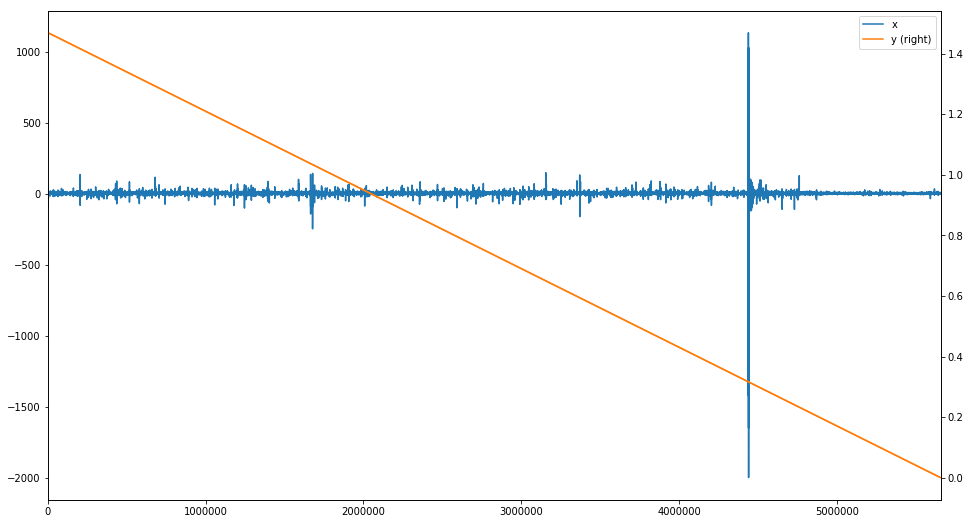

In [4]:
df.loc[::100,:].plot(figsize=(16,9), secondary_y=["y"])

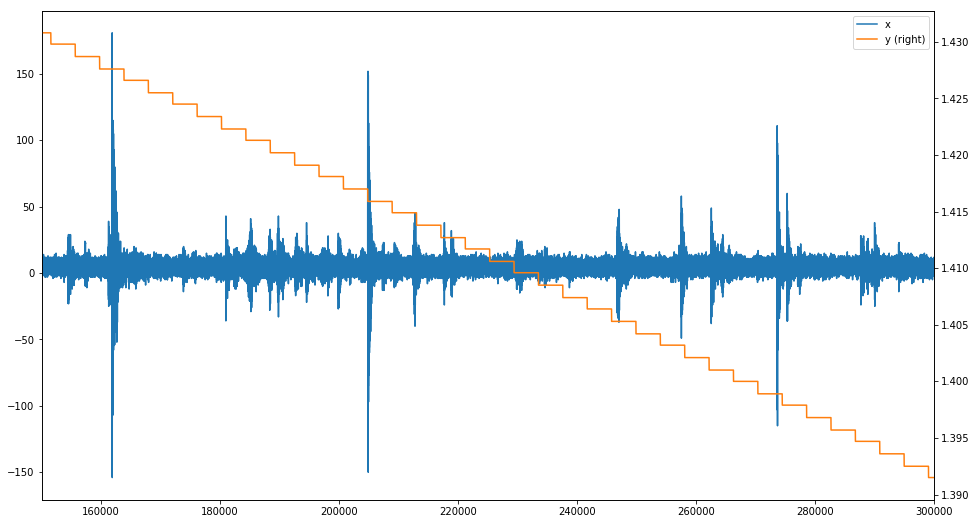

In [107]:
block = 150000
num = 1
df.loc[num * block: (num + 1) * block].plot(figsize=(16,9), secondary_y=["y"])

In [6]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import pacf, acf

In [116]:
pacf(df.loc[num * block: (num + 1) * block].x, nlags=1)[1:]

array([0.70609394])

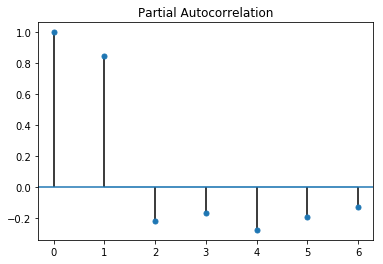

In [109]:
_ = tsaplots.plot_pacf(df.loc[num * block: (num + 1) * block].x, lags=6)

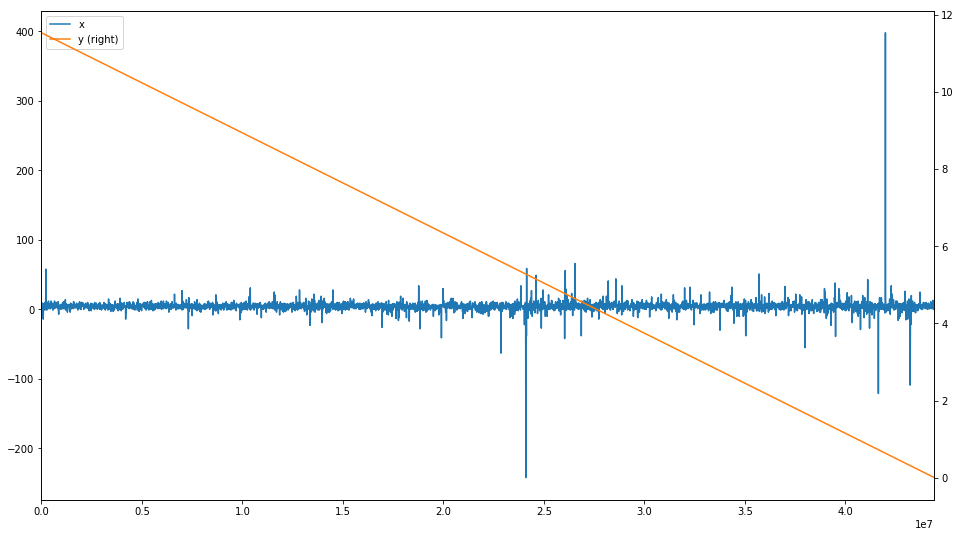

In [110]:
df = pd.read_csv(raw_data, skiprows=5656574, nrows=44429303)
df.columns = ["x", "y"]
df.loc[::10000,:].plot(figsize=(16,9), secondary_y=["y"])

In [38]:
summary = []
for name in tqdm_notebook(pd.read_csv(sub_data).seg_id):
    summary.append(pd.read_csv(test_data.format(name)).describe())

In [69]:
def yield_train_blocks(chunksize=150000):
    yield from pd.read_csv(
        raw_data, 
        names=["x", "y"], 
        dtype={"x": "int32", "y": "float32"}, 
        skiprows=1, 
        chunksize=chunksize
    )

In [70]:
def yield_sub_series():
    min_y = None
    blocks = []
    for block in yield_train_blocks():
        blocks.append(block)
        block_min_time = block.y.min()
        if min_y is None or block_min_time < min_y:
            min_y = block_min_time
            continue
        df = pd.concat(blocks, ignore_index=True)
        end_of_series = df.y.idxmin()
        blocks = [df.loc[end_of_series+1:]]
        min_y = blocks[0].y.min()
        yield df.loc[:end_of_series]
    yield pd.concat(blocks, ignore_index=True)

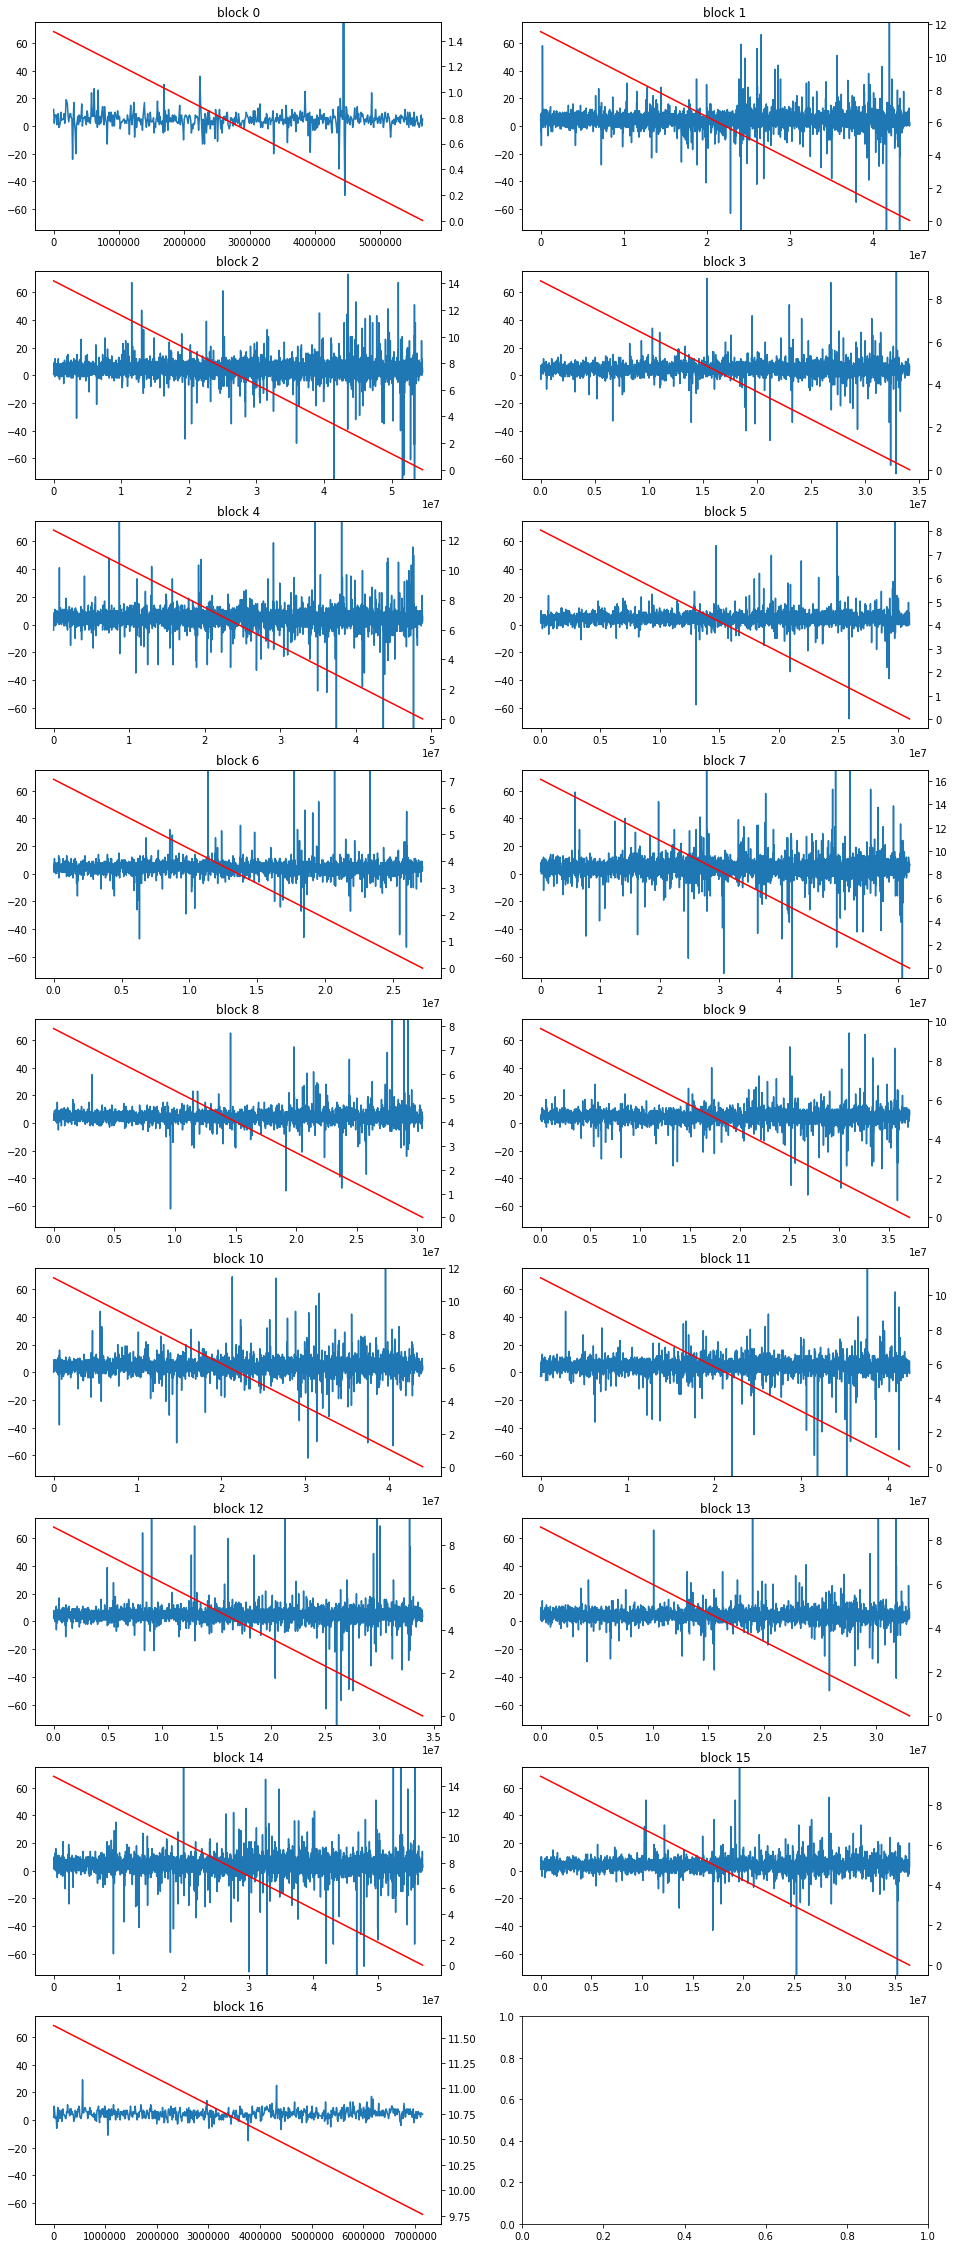

In [72]:
_, axs = plt.subplots(9, 2, figsize=(16, 9 * 9 / 2))
axs = axs.flatten()
for i, df in tqdm_notebook(enumerate(yield_sub_series())):
    axs[i].set_title(f"block {i}") 
    ax2 = axs[i].twinx()
    axs[i].set_ylim(-75, 75)
    step = len(df) // 5000
    axs[i].plot(df.x.loc[::step])   
    ax2.plot(df.y.loc[::step], color='r')   

# Анализ признаков

In [1]:
def yield_train_blocks(chunk_size=150000):
    dfs_gen = pd.read_csv(
        raw_data,
        names=["x", "y"],
        dtype={"x": "int32", "y": "float32"},
        skiprows=1,
        chunksize=chunk_size
    )
    for df in dfs_gen:
        time = df.y
        first_time = time.iloc[0]
        last_time = time.iloc[-1]
        if first_time < last_time:
            continue
        if len(df) == chunk_size:
            df.reset_index(drop=True, inplace=True)
            yield df.x, last_time

In [67]:
import nolds
# https://pypi.org/project/nolds/

In [10]:
data = []
for df_x, y in tqdm_notebook(yield_train_blocks()):
    data.append([pacf(df_x, nlags=12), y])

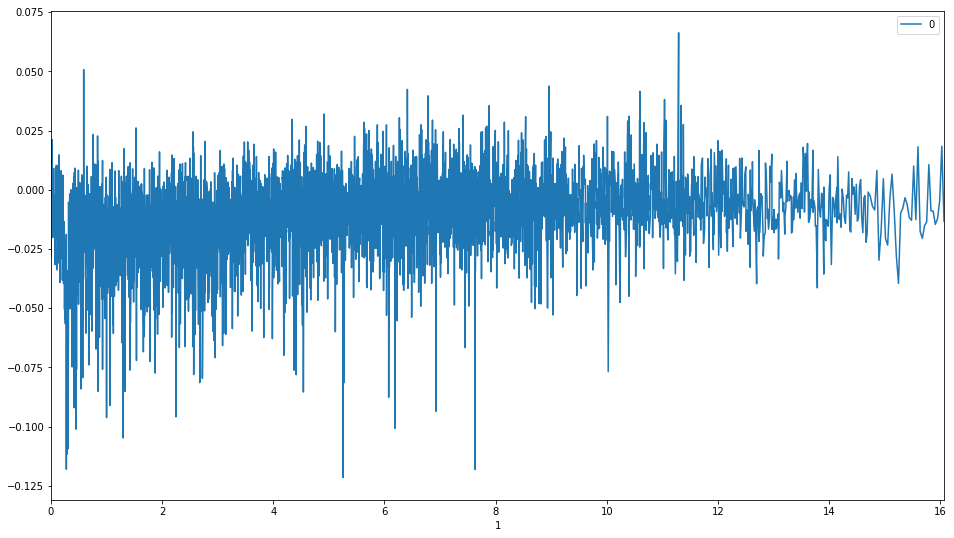

In [135]:
# pafc 12
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

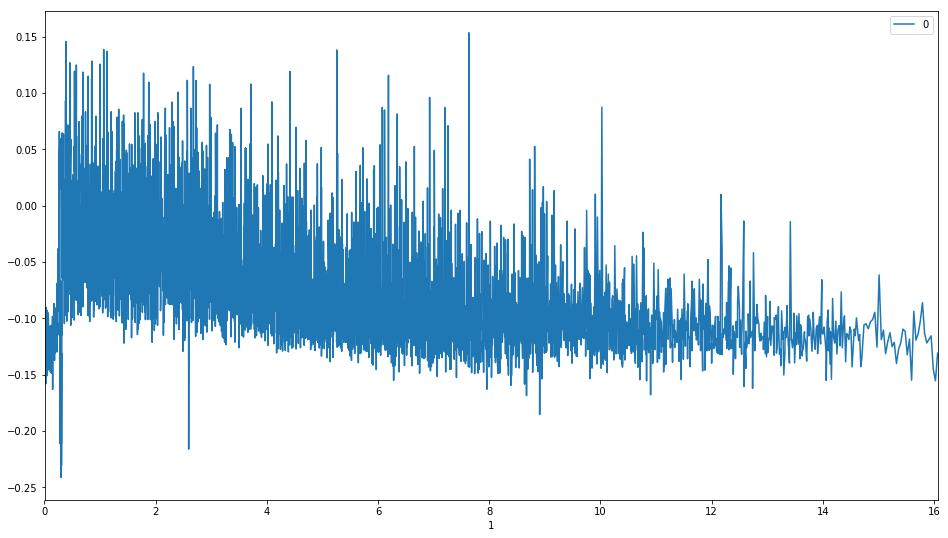

In [132]:
# pafc 7
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

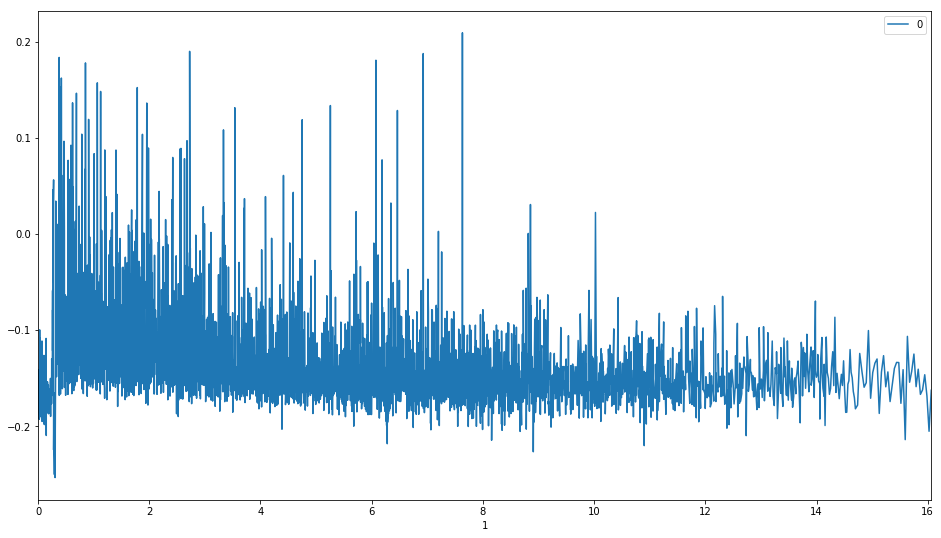

In [130]:
# pafc 6 - тут похоже короткий кусок наиболее отделим
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

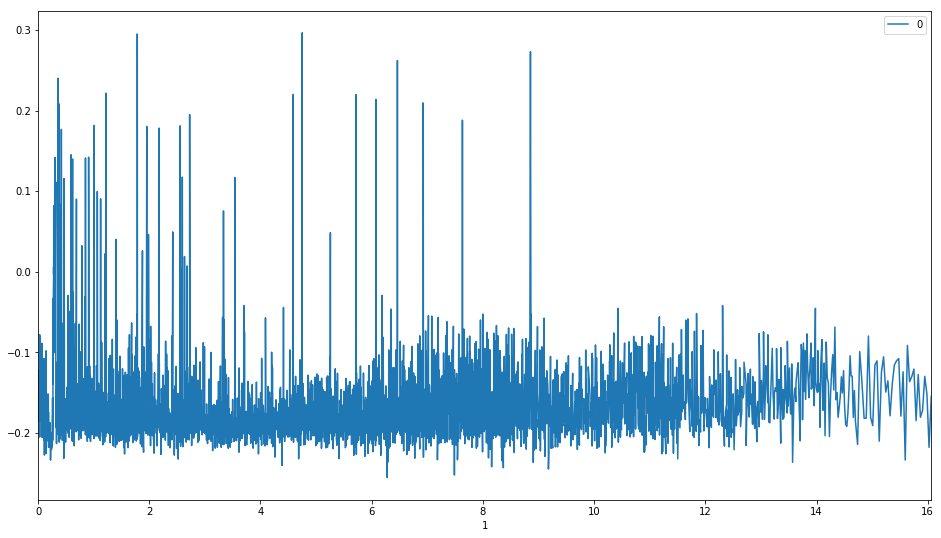

In [128]:
# pafc 5
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

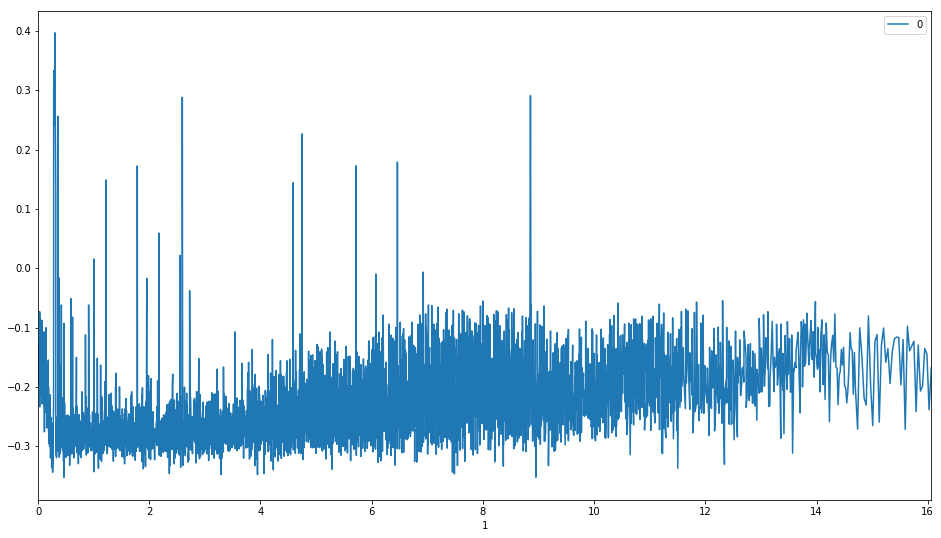

In [126]:
# pafc 4
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

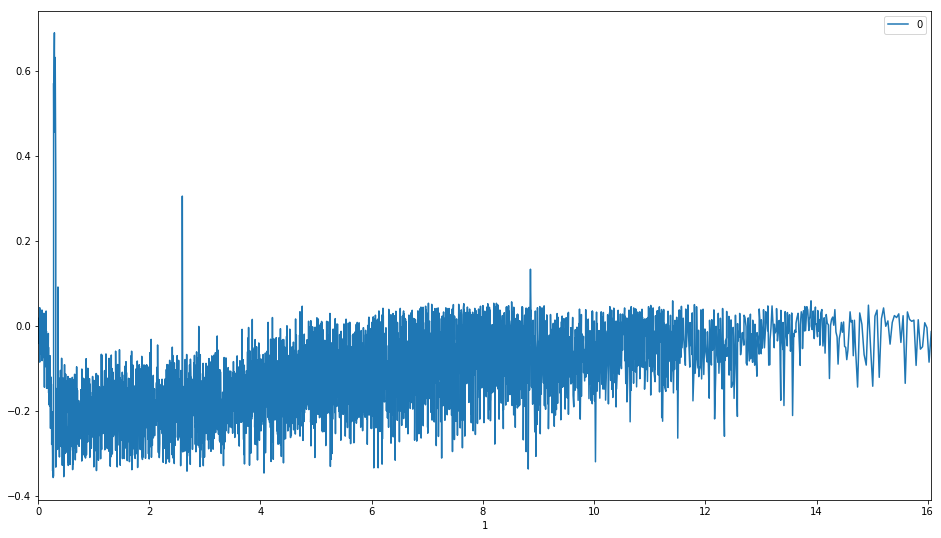

In [124]:
# pafc 3
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

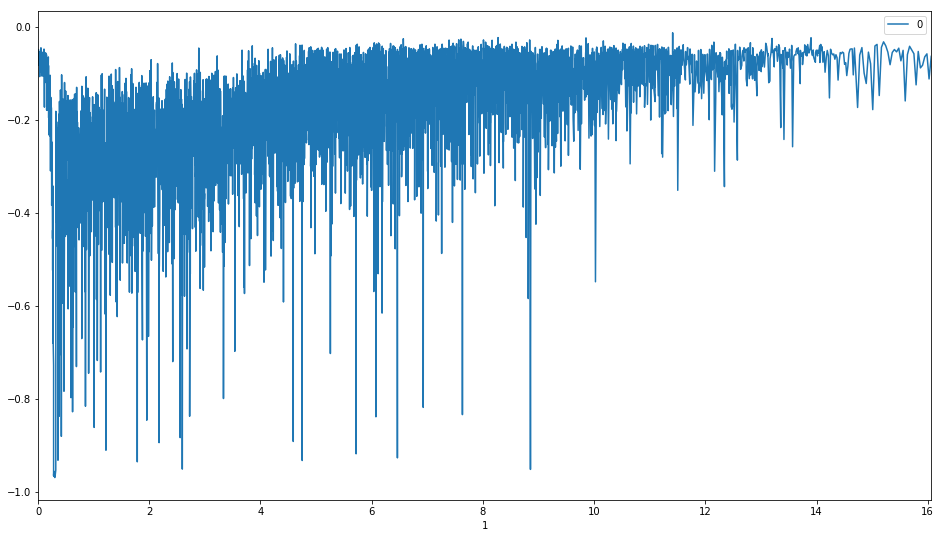

In [122]:
# pafc 2
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

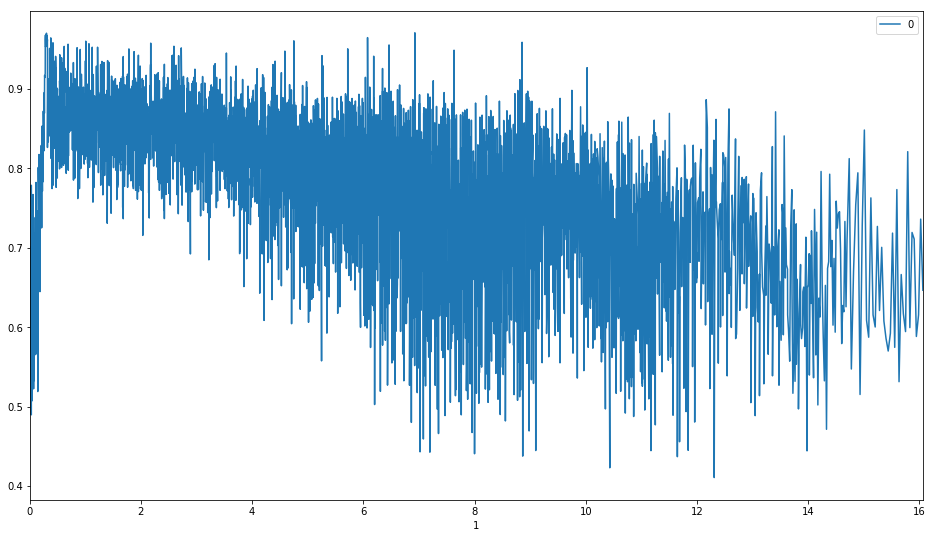

In [120]:
# pafc 1
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

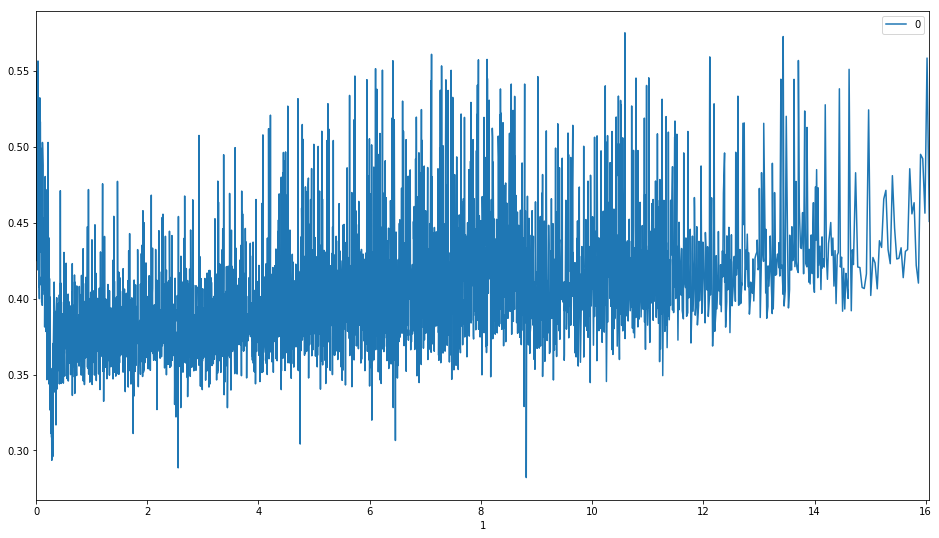

In [71]:
# hurst_rs
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9))

# Анализ OOF предсказания

In [12]:
df = pd.read_pickle(proc_data.format("oof.pickle"))

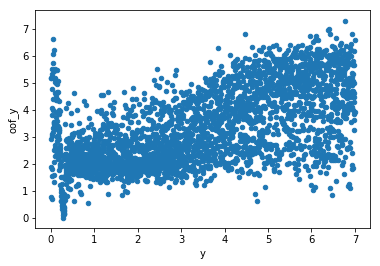

In [13]:
df.plot.scatter("y", "oof_y")

In [14]:
df["oof_y"] = (df["oof_y"] - df["y"]).abs()
rez = df.groupby(lambda x: int(df.y.loc[x] * 10) / 10).agg({"oof_y": ["mean"]})

In [15]:
df.oof_y.min()

8.166788678387604e-05

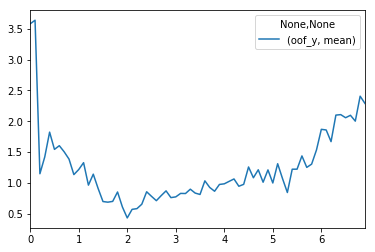

In [16]:
rez.plot()

# Важность признаков

In [79]:
pd.read_pickle(proc_data.format("importance.pickle"))

,1
0,
std_roll_med_375,46.713338
mean,11.021293
std_roll_min_375,8.232850
std_roll_half_pct,7.795753
mean_abs_med,7.601241
kurt,6.955401
std,5.850993
mean_abs_min,5.829131
